In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob #finding files whose names match a certain pattern, like *.wav or *.mp3

import librosa #for loading and processing audio files.
import librosa.display # to be able to listen to aydio file in python notebook
import IPython.display as ipd



In [7]:
#using glob get all audio files in variable (patternmaatching)
audio_files = glob('TESS Toronto emotional speech set data/*/*.wav')

In [9]:
# Play audio file
ipd.Audio(audio_files[3])

In [10]:
# now read the audio file for notebook
# y → The audio signal data
# sr → The rate at which that signal was sampled

y, sr = librosa.load(audio_files[3])
print(f'y: {y}')

y: [ 7.3401234e-06 -1.8113297e-04 -9.7328812e-05 ... -1.3968028e-04
 -1.0964635e-04  0.0000000e+00]


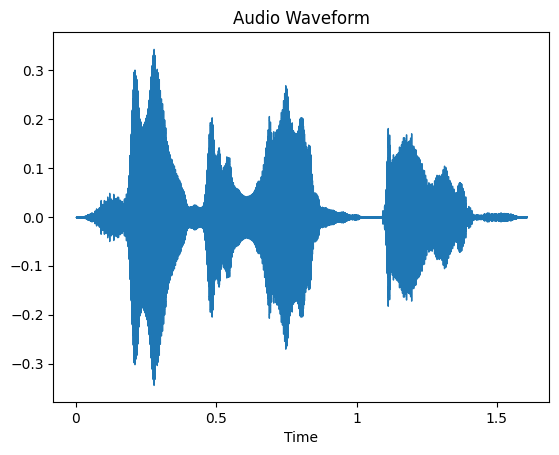

In [11]:
librosa.display.waveshow(y, sr=sr)
plt.title("Audio Waveform")
plt.show()

In [12]:
audio_files[:5]

['TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [14]:
import os
labels =[]
for file in audio_files:
    emotion = os.path.basename(os.path.dirname(file)).split('_')[-1].lower()
    labels.append(emotion)
    

In [16]:
df = pd.DataFrame()
df["audio_path"] = audio_files
df["labels"] = labels
df.head()

,audio_path,labels
0,TESS Toronto emotional speech set data\OAF_ang...,angry
1,TESS Toronto emotional speech set data\OAF_ang...,angry
2,TESS Toronto emotional speech set data\OAF_ang...,angry
3,TESS Toronto emotional speech set data\OAF_ang...,angry
4,TESS Toronto emotional speech set data\OAF_ang...,angry


In [17]:
df['labels'].value_counts()

labels
angry        400
disgust      400
fear         400
happy        400
neutral      400
sad          400
surprise     200
surprised    200
Name: count, dtype: int64

In [18]:
df['labels'] = df['labels'].str.lower().replace('surprised', 'surprise')

In [19]:
df['labels'].value_counts()

labels
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64

## EDA

In [20]:
def waveplot(y, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(y, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

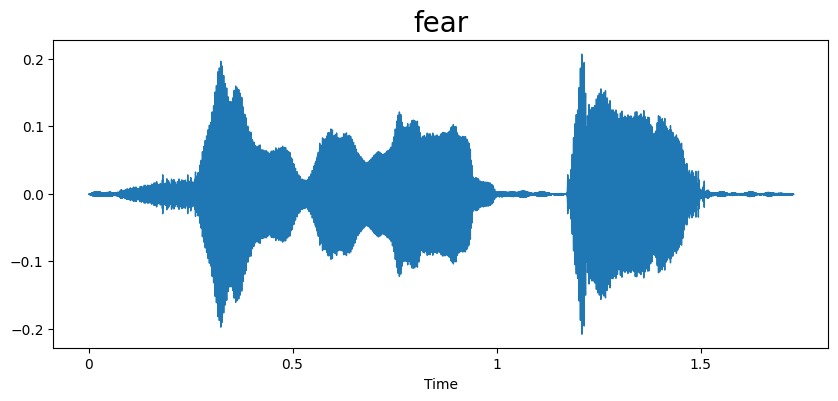

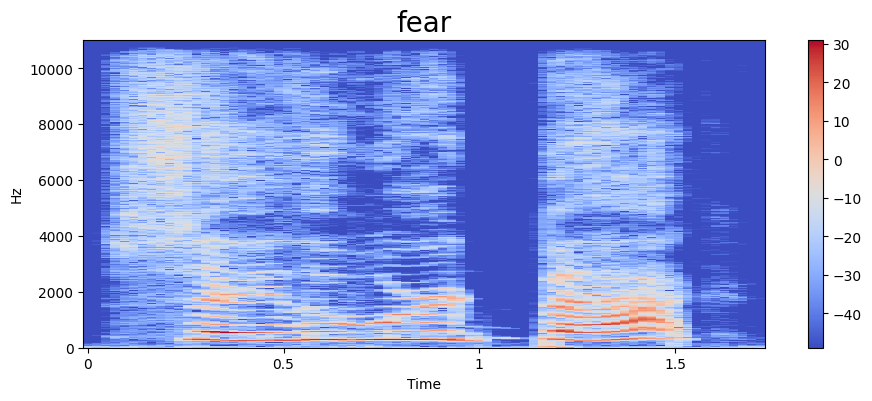

In [21]:
emotion = 'fear'
path = np.array(df['audio_path'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
ipd.Audio(path)

## FEATURE EXTRACTION


# mfcc 
 it tell the model - “How does this sound feel to human hearing?”(MFCC turns the raw sound (audio signal) into numbers that describe how the sound feels or sounds to a human ear.)
These numbers (features) tell the model:

- how sharp or flat the voice is,

- how energy is distributed across frequencies,

- and how it changes over time.

So instead of giving the model millions of waveform samples,
we give it a small set of meaningful features that capture the essence of the sound.
# Why MFCCs Are Used in SER

They capture voice texture, tone, and energy distribution — which differ for emotions like angry, sad, calm, etc.

They’re compact (just 13–40 features per frame instead of thousands of raw samples).

Work great with ML/DL models (CNNs, RNNs, etc.).
When plotted over time, it looks like a heatmap — darker or lighter areas show how the vocal energy shifts across frequency bands.


Example:

When someone says “Hello”:

The raw waveform: millions of ups and downs.

The MFCC: [ -320, 115, -27, 4, ... ] — just 40 meaningful numbers!

These 40 numbers capture the voice’s character —
and that’s what helps your emotion recognition model learn that “this voice sounds happy” or “this sounds sad”.

mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0) - explanation

librosa.mfcc ->
 - distributes the audio in chunks(called time frame)
 - for each time frame Extracts 40 coefficients(feature on basis of tone pitch etc(black box))
.T(transpose)->
- Transposes the array to shape (number_of_time_frames, 40) (so each row is one time frame, each column one coefficient).
then mean -> This compresses the temporal information and gives a fixed-length feature vector

In [22]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    #duration=3 → Loads only 3 seconds of the audio file.(useful for making all samples the same length)
    #offset=0.5 → Starts reading after 0.5 seconds (skipping initial silence or noise).
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [23]:
extract_mfcc(df['audio_path'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275601e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228313e+00, -5.57366073e-01, -1.83255339e+00,  2.02101454e-01,
        7.27551103e-01,  1.31773746e+00,  2.88633752e+00,  2.85579062e+00,
       -4.71292162e+00, -4.43651056e+00, -1.62115955e+00, -1.02398405e+01,
       -7.55126190e+00, -1.79688025e+00, -7.03765249e+00,  9.43658352e+00,
        8.35585308e+00,  2.17123604e+01,  1.92169914e+01,  2.03489304e+01,
        1.34133663e+01,  8.33917236e+00,  3.94722104e-01,  5.11131477e+00,
        9.56873894e+00,  5.45486832e+00,  2.50996327e+00, -1.82390726e+00,
        4.86896229e+00,  9.31392384e+00,  2.08915043e+00, -1.90649140e+00],
      dtype=float32)

In [67]:
X_mfcc = df['audio_path'].apply(lambda x: extract_mfcc(x))

In [68]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [69]:
#LSTMs with Conv layers — expect inputs to have a channel dimension. 
#Here, since we only have one “channel” (not RGB, just one MFCC feature map), we set it to 1.
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [70]:
#encoding label col 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Step 1: Convert text labels → integer labels
le = LabelEncoder()
y_int = le.fit_transform(df['labels'])#one_hot 

y_encoded = to_categorical(y_int) 
y_encoded.shape

(2800, 7)

In [71]:
le.classes_


array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

## CREATE THE MODEL

Audio is a sequence that changes over time.
When you speak or play music, every millisecond adds a new sound wave — so your data is time-series.
That’s where LSTM (Long Short-Term Memory networks) come in.

In [66]:
# import tensorflow as tf
# tf.compat.v1.enable_eager_execution()


In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()

# Bidirectional LSTM layer (captures past + future context)
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second LSTM layer (learns deeper temporal features)
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Dense layer for high-level features
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Show model summary
model.summary()




C:\python\python 312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 40, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,719 (1.17 MB)

 Trainable params: 306,951 (1.17 MB)

 Non-trainable params: 768 (3.00 KB)

In [73]:
from sklearn.model_selection import train_test_split

# First split: Train + temp
X_train, X_temp, y_train, y_temp, y_int_train, y_int_temp = train_test_split(
    X, y_encoded, y_int,
    test_size=0.3,
    stratify=y_int,
    random_state=42
)

# Second split: Validation + Test
X_val, X_test, y_val, y_test, y_int_val, y_int_test = train_test_split(
    X_temp, y_temp, y_int_temp,
    test_size=0.5,
    stratify=y_int_temp,
    random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (1960, 40, 1)
Val: (420, 40, 1)
Test: (420, 40, 1)


In [74]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6082 - loss: 1.1373 - val_accuracy: 0.7667 - val_loss: 1.0479
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8541 - loss: 0.4200 - val_accuracy: 0.9143 - val_loss: 0.4126
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9204 - loss: 0.2341 - val_accuracy: 0.9476 - val_loss: 0.1515
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9408 - loss: 0.1833 - val_accuracy: 0.9595 - val_loss: 0.1232
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9551 - loss: 0.1528 - val_accuracy: 0.9595 - val_loss: 0.1221
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9531 - loss: 0.1436 - val_accuracy: 0.9810 - val_loss: 0.0500
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9607 - loss: 0.1162 - val_accuracy: 0.9762 - val_loss: 0.0732
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9566 - loss: 0.1314 - val_accuracy: 0.9833 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


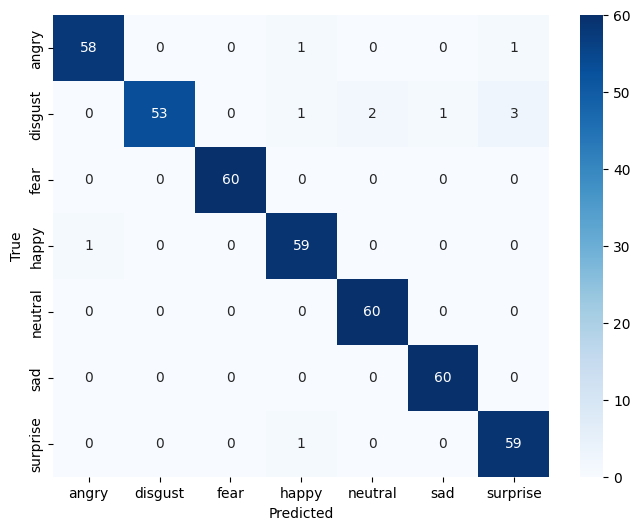

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))


              precision    recall  f1-score   support

       angry       0.98      0.97      0.97        60
     disgust       1.00      0.88      0.94        60
        fear       1.00      1.00      1.00        60
       happy       0.95      0.98      0.97        60
     neutral       0.97      1.00      0.98        60
         sad       0.98      1.00      0.99        60
    surprise       0.94      0.98      0.96        60

    accuracy                           0.97       420
   macro avg       0.97      0.97      0.97       420
weighted avg       0.97      0.97      0.97       420



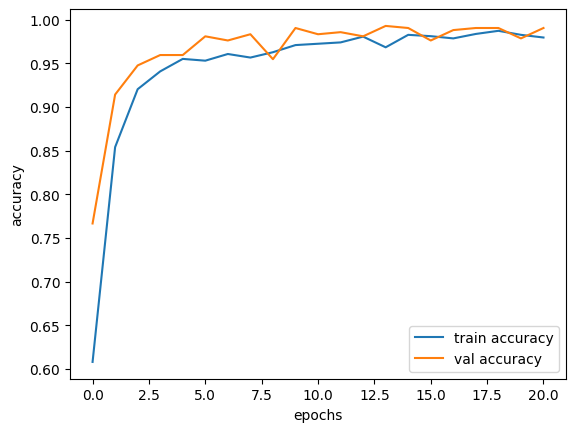

In [77]:
epochs = list(range(21))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

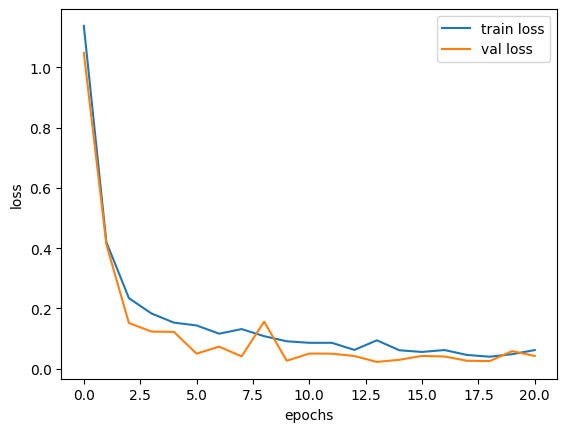

In [78]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [79]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9929 - loss: 0.0225
Test Accuracy: 0.99
Test Loss: 0.02


In [80]:
model.save('ser_lstm_model.h5')
print("Model saved successfully ")


Model saved successfully 


In [87]:
# Example: predict a single file
file = 'TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav'
Emotions= ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
# Extract features
mfcc = extract_mfcc(file)
mfcc = np.expand_dims(mfcc, axis=(0, -1))  # shape = (1, 40, 1)

# Predict
pred = model.predict(mfcc)
print(pred)
emotion_idx = np.argmax(pred)
print(emotion_idx)
predicted_emotion = Emotions[emotion_idx]  # if you used a label map dict earlier

print("Predicted Emotion:", predicted_emotion)
print("Confidence:", np.max(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
[[9.9990141e-01 2.3356113e-06 3.2546450e-05 5.8070009e-06 7.5871089e-06
  3.5674002e-05 1.4510394e-05]]
0
Predicted Emotion: angry
Confidence: 0.9999014


## Realtime

In [36]:
# pip install sounddevice scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [82]:
import sounddevice as sd
import numpy as np
import librosa
import tensorflow as tf

# Load your pre-trained model
model = tf.keras.models.load_model("ser_lstm_model.h5")
Emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

sr = 22050  # sampling rate
duration = 7  # seconds

print("🎙️ Speak now...")
audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
sd.wait()
print("Recording complete!")

# Extract MFCC features
mfcc = librosa.feature.mfcc(y=audio.flatten(), sr=sr, n_mfcc=40)
mfcc = np.mean(mfcc.T, axis=0)
mfcc = np.expand_dims(mfcc, axis=(0, -1))

# Predict emotion
pred = model.predict(mfcc)
print("Detected emotion:", Emotions[np.argmax(pred)])


🎙️ Speak now...
Recording complete!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
Detected emotion: happy
